In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from typing import Literal
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
file_path = '/content/balanced_df_ohe.pkl'
balanced_df_ohe = pd.read_pickle(file_path)

In [ ]:
def df_add_label(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    status_ohe = df[['status_healthy','status_symptomatic','status_COVID-19']].values
    df['label'] = np.argmax(status_ohe, axis=1)
    return df

df_labeled = df_add_label(balanced_df_ohe)

train_df, val_df = train_test_split(
    df_labeled,
    test_size=0.2,
    random_state=SEED,
    stratify=df_labeled['label']
)

class CoughDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.images = df['image'].values
        self.labels = df['label'].values.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        # move channel first: (H, W, 3) → (3, H, W)
        img = torch.from_numpy(img).permute(2,0,1)
        label = torch.tensor(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, label

BATCH_SIZE = 32

train_ds = CoughDataset(train_df)
val_ds   = CoughDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

_, sample = next(iter(train_loader))
imgs, labels = next(iter(train_loader))
_, _, img_h, img_w = imgs.shape
print(f"Detected image size: {img_h}×{img_w}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN(img_h, img_w, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


class SimpleCNN(nn.Module):
    def __init__(self, img_h, img_w, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64,128, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)
        feat_dim = 128 * (img_h//8) * (img_w//8)
        self.fc1 = nn.Linear(feat_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x)); x = self.pool(x)
        x = F.relu(self.conv2(x)); x = self.pool(x)
        x = F.relu(self.conv3(x)); x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model = SimpleCNN(img_h, img_w, num_classes=3).to(device)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 25
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total

    # -- validate --
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = correct / total

    print(f"Epoch {epoch:02d} | "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.3f}")

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_covid_cnn.pt")

print(f"Best val acc: {best_val_acc:.3f}")

Detected image size: 64×64
Epoch 01 | Train: loss=1.1022, acc=0.342 | Val:   loss=1.0977, acc=0.360
Epoch 02 | Train: loss=1.0967, acc=0.356 | Val:   loss=1.1012, acc=0.351
Epoch 03 | Train: loss=1.0939, acc=0.369 | Val:   loss=1.0970, acc=0.349
Epoch 04 | Train: loss=1.0949, acc=0.370 | Val:   loss=1.0931, acc=0.381
Epoch 05 | Train: loss=1.0916, acc=0.385 | Val:   loss=1.0926, acc=0.383
Epoch 06 | Train: loss=1.0904, acc=0.383 | Val:   loss=1.0888, acc=0.387
Epoch 07 | Train: loss=1.0871, acc=0.387 | Val:   loss=1.0913, acc=0.384
Epoch 08 | Train: loss=1.0861, acc=0.379 | Val:   loss=1.0894, acc=0.385
Epoch 09 | Train: loss=1.0842, acc=0.382 | Val:   loss=1.0912, acc=0.369
Epoch 10 | Train: loss=1.0806, acc=0.399 | Val:   loss=1.0932, acc=0.349
Epoch 11 | Train: loss=1.0795, acc=0.403 | Val:   loss=1.0908, acc=0.369
Epoch 12 | Train: loss=1.0738, acc=0.414 | Val:   loss=1.0962, acc=0.343
Epoch 13 | Train: loss=1.0661, acc=0.421 | Val:   loss=1.0991, acc=0.384
Epoch 14 | Train: loss=1

Classification Report:
              precision    recall  f1-score   support

     healthy       0.36      0.35      0.36       263
 symptomatic       0.36      0.27      0.31       263
    COVID-19       0.41      0.52      0.46       263

    accuracy                           0.38       789
   macro avg       0.38      0.38      0.38       789
weighted avg       0.38      0.38      0.38       789



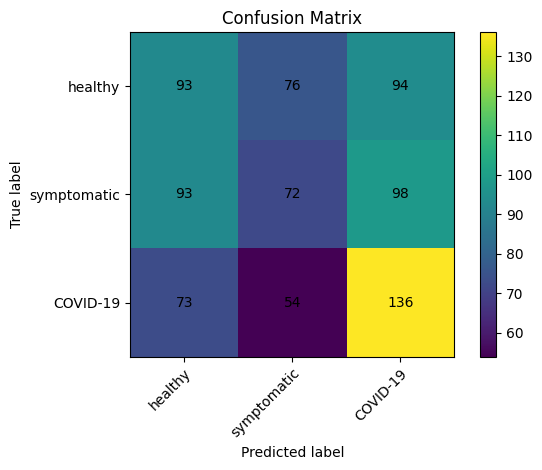

In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print classification report
print("Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=['healthy','symptomatic','COVID-19']
))

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
classes = ['healthy','symptomatic','COVID-19']
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel='Predicted label',
    ylabel='True label',
    title='Confusion Matrix'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotate counts in each cell
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()